In [ ]:
# Import tensorflow dataset
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
import pandas as pd
from tqdm import tqdm
import numpy as np

ds = tfds.load(name='gigaword')

Shuffling and writing examples to /root/tensorflow_datasets/gigaword/1.2.0.incomplete3EUX3X/gigaword-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/gigaword/1.2.0.incomplete3EUX3X/gigaword-validation.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/gigaword/1.2.0.incomplete3EUX3X/gigaword-test.tfrecord
Dataset gigaword downloaded and prepared to /root/tensorflow_datasets/gigaword/1.2.0. Subsequent calls will reuse this data.


In [ ]:
# Convert tensorflow dataset to pairs

train_size = 300000
valid_size = 10000
test_size = -1

def example_pair(example):
    src = example['document'].decode('utf-8')
    trg = example['summary'].decode('utf-8')
    return [src, trg]

def tfds_pairs(ds, size):
    pairs = []
    ds = tfds.as_numpy(ds)
    tbar = tqdm(ds)
    for example in tbar:
        pairs.append(example_pair(example))
        if len(pairs) == size: 
            tbar.close()
            break
    return pairs

train_pairs = tfds_pairs(ds['train'], train_size)
valid_pairs = tfds_pairs(ds['validation'], valid_size)
test_pairs = tfds_pairs(ds['test'], test_size)

print('Number of train examples: {}'.format(len(train_pairs)))
print('Number of valid examples: {}'.format(len(valid_pairs)))
print('Number of test examples: {}'.format(len(test_pairs)))

299627it [01:16, 3923.49it/s]
9588it [00:02, 3830.71it/s]
1951it [00:00, 3503.10it/s]

Number of train examples: 300000
Number of valid examples: 10000
Number of test examples: 1951


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0, 0.5, 'proportion')

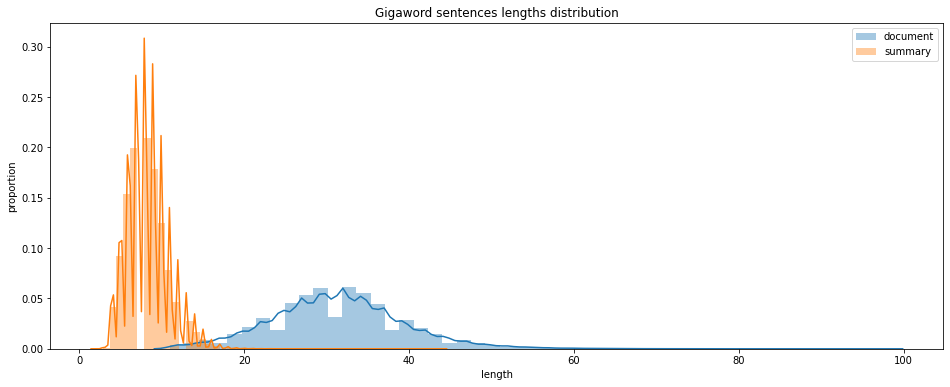

In [ ]:
# Show lengths distribution of train data
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16, 6))

src_len = []
trg_len = []
for pair in train_pairs:
    src_len.append(len(pair[0].split()))
    trg_len.append(len(pair[1].split()))

sns.distplot(src_len, label='document')
sns.distplot(trg_len, label='summary')
plt.legend()
plt.title('Gigaword sentences lengths distribution')
plt.xlabel('length')
plt.ylabel('proportion')


In [ ]:
# Preprocess data
# 1. Text cleaning
# 2. Filter outliers
import re

# Set limits of the lengths
max_src_len = 45
min_src_len = 18
max_trg_len = 13
min_trg_len = 5

def clean_sent(sent):
    sent = sent.lower()
    sent = re.sub(r'-.*-', ' ', sent) # Removes word inside - -
    sent = re.sub(r'#.*#', '##', sent) # Removes word inside # #
    # Handle numbers in sent
    sent = re.sub(r'([a-z0-9.,<>])(#)', r'\1 \2', sent)
    sent = re.sub(r'(#)([a-z0-9.,<>])', r'\1 \2', sent)
    sent = re.sub(r'#{1,}', r'#', sent)
    sent = sent.replace('#', '<NUM>')
    # Remove special symbols
    sent = re.sub(r'[^a-zA-Z.,/-<>#\']', ' ', sent) 
    sent = sent.replace('/', ' ')
    sent = sent.replace(';', ' ')
    sent = sent.replace('<num>', ' <NUM> ')
    sent = sent.split()
    sent = [word for word in sent if len(word) > 1 or word in ['i', 'a']]
    sent = ' '.join(sent)
    return sent

def clean_pair(pair):
    src = clean_sent(pair[0])
    trg = clean_sent(pair[1])
    return [src, trg]

def clean_pairs(pairs):
    return [clean_pair(pair) for pair in pairs]

def filter_pairs(pairs):
    filtered = []
    for pair in pairs:
        src, trg = pair
        src_len = len(src.split())
        trg_len = len(trg.split())
        if 'unk' not in pair[0] and 'unk' not in pair[1]: # Remove default unk
            if min_src_len <= src_len <= max_src_len and min_trg_len <= trg_len <= max_trg_len: # Remove outliers
                filtered.append(pair)
    return filtered

train_pairs = filter_pairs(clean_pairs(train_pairs))
valid_pairs = filter_pairs(clean_pairs(valid_pairs))
test_pairs = filter_pairs(clean_pairs(test_pairs))

print('Number of train examples: {}'.format(len(train_pairs)))
print('Number of valid examples: {}'.format(len(valid_pairs)))
print('Number of test examples: {}'.format(len(test_pairs)))


Number of train examples: 208647
Number of valid examples: 6644
Number of test examples: 909


In [ ]:
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Custom vocab object
class Vocab():
   
    def __init__(self):
        self.PAD = 0
        self.SOS = 1
        self.EOS = 2
        self.UNK = 3
        self.NUM = 4
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>", 4: "<NUM>"}
        self.n_words = 5

    def add_sent(self, sentence):
        for word in sentence.split():
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def __getitem__(self, item):
        if type(item) == str:
            return int(self.word2index.get(item, self.UNK)) # Return the index of <UNK> if input word is not in the vocab
        elif type(item) == int:
            return self.index2word[item]

In [ ]:
# Build vocab from train data

def build_vocab(pairs):
    vocab = Vocab()
    print("Read {} example pairs".format(len(pairs)))
    for pair in pairs:
        vocab.add_sent(pair[0])
        vocab.add_sent(pair[1])
    print('Number of vocab: {}'.format(vocab.n_words))
    
    return vocab

vocab = build_vocab(train_pairs)

Read 208647 example pairs
Number of vocab: 64514


In [ ]:
# Convert pairs into batches of pairs

def batchify(pairs, batch_size):
    # Convert a dataset into a list of batches
    # Sort all example pairs in descending order: src_len
    pairs = sorted(pairs, key=lambda p: len(p[0].split()), reverse=True)
    pairs = [pairs[i:i+batch_size] for i in range(0, len(pairs), batch_size)]
    return pairs

In [ ]:
class Encoder(nn.Module):

    def __init__(self, emb_dim, hid_dim):
        super(Encoder, self).__init__()
        self.hid_dim = hid_dim
        self.gru = nn.GRU(emb_dim, hid_dim)

    def forward(self, embedded, hidden): # embedded [src_len, batch_size, emb_dim] 
        output, hidden = self.gru(embedded, hidden)
        return output, hidden
        # output [src len, batch size, hid dim]
        # hidden [1, batch size, hid dim]

    def initHidden(self):
        return torch.zeros(1, 1, self.hid_dim, device=device) # [1, 1, hid_dim]

In [ ]:
class Decoder(nn.Module):

    def __init__(self, output_dim, emb_dim, hid_dim):
        super(Decoder, self).__init__()
        
        self.output_dim = output_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.gru = nn.GRU(emb_dim, hid_dim)
        self.generator = nn.Linear(hid_dim, output_dim, bias=False)

    def forward(self, embedded, hidden, encoder_outputs):
        # embedded [1, batch_size, emb_dim]
        # encoder_outputs [src_len, batch_size, hid_dim]
        # hidden [1, batch size, hid dim]

        output, hidden = self.gru(embedded, hidden)
        # output = [1, batch_size, hid_dim]
        # hidden = [1, batch_size, hid_dim]
        word_dist = F.log_softmax(self.generator(hidden.squeeze(0)), dim=1) # [batch_size, output_dim]

        return word_dist, hidden

In [ ]:
class Model(nn.Module):
    def __init__(self, vocab_dim, emb_dim, hid_dim):
        super(Model, self).__init__()
        self.embedding = nn.Embedding(vocab_dim, emb_dim).to(device)
        self.encoder = Encoder(emb_dim, hid_dim).to(device)
        self.decoder = Decoder(vocab_dim, emb_dim, hid_dim).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
def encode_sent(vocab, sent):
    return [vocab[word] for word in sent.split()] + [vocab.EOS]

def encode_pair(vocab, pair):
    src = encode_sent(vocab, pair[0])
    trg = encode_sent(vocab, pair[1])
    return src, trg

def encode_batch(vocab, batch):
    return [encode_pair(vocab, pair) for pair in batch]

def pad_sent(sent, max_len):
    # Post-padding
    sent += [vocab.PAD]*(max_len - len(sent))
    return sent

def tensor_batch(vocab, batch):
  
    # Encode batch
    batch = encode_batch(vocab, batch)
    
    src = [pair[0] for pair in batch]
    trg = [pair[1] for pair in batch]
    src_len = [len(sent) for sent in src]
    trg_len = [len(sent) for sent in trg]
    
    # Padding
    src = [pad_sent(sent, max(src_len)) for sent in src]
    trg = [pad_sent(sent, max(trg_len)) for sent in trg]
    
    # Convert to tensor
    src =  torch.tensor(src, dtype=torch.long, device=device).transpose(0, 1) # [src_len, batch_size]
    trg =  torch.tensor(trg, dtype=torch.long, device=device).transpose(0, 1) # [trg_len, batch_size]
    src_len = torch.tensor(src_len, dtype=torch.long, device=device) # [batch_size]
    trg_len = torch.tensor(trg_len, dtype=torch.long, device=device) # [batch_size]
    
    return [[src, trg], [src_len, trg_len]]

In [ ]:
def train(batches, model, optimizer, criterion):

    epoch_loss = []
    tbar = tqdm(batches, leave=True)
    for batch in tbar:

        optimizer.zero_grad()
        
        batch = tensor_batch(vocab, batch)
        src = batch[0][0] # [max_src_len, batch_size]
        trg = batch[0][1] # [max_trg_len, batch_size]
        batch_size = src.size(1)
        max_trg_len = trg.size(0)

        ## Encoder
        encoder_hidden = model.encoder.initHidden().repeat(1, batch_size, 1) # [1, batch_size, hid_dim], initial encoder input
        embedded = model.embedding(src)
        encoder_outputs, encoder_hidden = model.encoder(embedded, encoder_hidden)
        # encoder_outputs [max_src_len, batch_size, hid_dim]
        # encoder_hidden [1, batch_size, hid_dim]

        ## Decoder
        word_dists = torch.zeros(max_trg_len, batch_size, model.decoder.output_dim).to(device) # [max_trg_len, batch_size, output_dim]
        decoder_input = torch.tensor([[vocab.SOS]], device=device) # [1, 1]
        decoder_input = decoder_input.repeat(1, batch_size)  # [1, batch_size], initial decoder input
        decoder_hidden = encoder_hidden # [1, batch_size, hid_dim], last encoder_hidden = first_decoder hidden

        for t in range(max_trg_len):
            embedded = model.embedding(decoder_input)
            word_dist, decoder_hidden = model.decoder(embedded, decoder_hidden, encoder_outputs)
            # word_dist [batch_size, output_dim]
            # decoder_hidden [1, batch_size, hid_dim]
            word_dists[t] = word_dist
            decoder_input = trg[t].unsqueeze(0) # [1, batch_size]

        word_dists = word_dists.view(-1, model.decoder.output_dim) # [batch_size * max_trg_len, output_dim]
        trg = trg.reshape(-1) # [batch_size * max_trg_len]

        loss = criterion(word_dists, trg) 

        loss.backward()
        optimizer.step()

        loss = loss.item()
        epoch_loss.append(loss)

        tbar.set_description("batch: {}\t batch train loss: {:.4f}".format(len(epoch_loss), loss))
    
    tbar.close()
    return epoch_loss

In [ ]:
def test(batches, model, criterion):

    with torch.no_grad():
        epoch_loss = []

        tbar = tqdm(batches, leave=True)
        for batch in tbar:
           
            batch = tensor_batch(vocab, batch)
            src = batch[0][0] # [max_src_len, batch_size]
            trg = batch[0][1] # [max_trg_len, batch_size]
            batch_size = src.size(1)
            max_trg_len = trg.size(0)

            ## Encoder
            encoder_hidden = model.encoder.initHidden().repeat(1, batch_size, 1) # [1, batch_size, hid_dim], initial encoder input
            embedded = model.embedding(src)
            encoder_outputs, encoder_hidden = model.encoder(embedded, encoder_hidden)
            # encoder_outputs [max_src_len, batch_size, hid_dim]
            # encoder_hidden [1, batch_size, hid_dim]

            ## Decoder
            word_dists = torch.zeros(max_trg_len, batch_size, model.decoder.output_dim).to(device) # [max_trg_len, batch_size, output_dim]
            decoder_input = torch.tensor([[vocab.SOS]], device=device) # [1, 1]
            decoder_input = decoder_input.repeat(1, batch_size)  # [1, batch_size], initial decoder input
            decoder_hidden = encoder_hidden # [1, batch_size, hid_dim], last encoder_hidden = first_decoder hidden

            for t in range(max_trg_len):
                embedded = model.embedding(decoder_input)
                word_dist, decoder_hidden = model.decoder(embedded, decoder_hidden, encoder_outputs)
                # word_dist [batch_size, output_dim]
                # decoder_hidden [1, batch_size, hid_dim]
                word_dists[t] = word_dist
                decoder_input = trg[t].unsqueeze(0) # [1, batch_size]

            word_dists = word_dists.view(-1, model.decoder.output_dim) # [batch_size * max_trg_len, output_dim]
            trg = trg.reshape(-1) # [batch_size * max_trg_len]

            loss = criterion(word_dists, trg) 

            loss = loss.item()
            epoch_loss.append(loss)
            tbar.set_description("batch: {}\t batch train loss: {:.4f}".format(len(epoch_loss), loss))

        tbar.close()
    return epoch_loss

In [ ]:
def inference(src, model):

    with torch.no_grad():

        src = encode_sent(vocab, src)
        src = torch.tensor(src, dtype=torch.long, device=device).unsqueeze(1) # [src_len, 1]
        src_len = src.size(0)
        
        ## Encoder
        embedded = model.embedding(src)
        encoder_hidden = torch.zeros(1, 1, model.encoder.hid_dim, device=device) # [1, 1, hid_dim]
        encoder_outputs, encoder_hidden = model.encoder(embedded, encoder_hidden) 
        # encoder_outputs [src len, 1, hid-dim]
        # encoder_hidden [1, 1, hid_dim]

        ## Decoder
        decoder_input = torch.tensor([[vocab.SOS]], device=device) # [1, 1]
        decoder_hidden = encoder_hidden # [1, 1, hid_dim], last encoder_hidden = first_decoder hidden
        pred_trg = []

        for t in range(src_len): # Must be shorter than the src_len otherwise it is not summarisation
            embedded = model.embedding(decoder_input)
            word_dist, decoder_hidden = model.decoder(embedded, decoder_hidden, encoder_outputs)
            # word_dist, [1, output_dim]
            # decoder_hidden [1, 1, hid_dim]

            prediction = word_dist.argmax(1) # [1]
            pred_trg.append(prediction.item())

            if pred_trg[-1] == vocab.EOS:
                break
            
            decoder_input = prediction.unsqueeze(0) # [1, 1]
        
        pred_trg = [vocab[idx] for idx in pred_trg]
        
        pred_trg = ' '.join(pred_trg)

        return pred_trg

In [ ]:
def inference_randomly(pairs, model, n=100):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_sentence = inference(pair[0], model)
        print('<', output_sentence)
        print('')

In [ ]:
import time

hid_dim = 300
emb_dim = 300
vocab_dim = vocab.n_words
n_epoch = 10
learning_rate = 0.001
batch_size = 128

train_batches = batchify(train_pairs, batch_size)
valid_batches = batchify(valid_pairs, batch_size)

model = Model(vocab_dim, hid_dim, emb_dim)
print(f'Embedding has {count_parameters(model.embedding):,} trainable parameters')
print(f'Encoder has {count_parameters(model.encoder):,} trainable parameters')
print(f'Decoder has {count_parameters(model.decoder):,} trainable parameters')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=vocab.PAD)

start = time.time()
best_valid_loss = float('inf')
train_losses = []
valid_losses = []

for epoch in range(1, n_epoch + 1):
    
    train_loss = train(iter(train_batches), model, optimizer, criterion)
    valid_loss = test(iter(valid_batches), model, criterion)

    print('epoch: {}\t epoch train loss: {:.4f}\t epoch valid loss: {:.4f}'.format(epoch, np.mean(train_loss), np.mean(valid_loss)))

    train_losses += train_loss
    valid_losses += valid_loss

    if np.mean(valid_loss) < best_valid_loss:
        best_valid_loss = np.mean(valid_loss)
        torch.save(model.state_dict(), 'model_1.w')

0it [00:00, ?it/s]

Embedding has 19,354,200 trainable parameters
Encoder has 541,800 trainable parameters
Decoder has 19,896,000 trainable parameters


batch: 1631	 batch train loss: 4.6754: : 1631it [11:03,  2.46it/s]
batch: 52	 batch train loss: 4.7398: : 52it [00:12,  4.28it/s]


epoch: 1	 epoch train loss: 5.8121	 epoch valid loss: 5.0689


batch: 604	 batch train loss: 4.5678: : 604it [04:07,  2.43it/s]

KeyboardInterrupt: ignored

In [ ]:
model.load_state_dict(torch.load('model_1.w'))
inference_randomly(test_pairs, model, n=5)

In [ ]:
def output_csv(pairs, model):
    reference = []
    candidate = []
    for pair in pairs:
        src = pair[0]
        trg = pair[1]
        pred_trg = inference(src, model)
        pred_trg = ' '.join(pred_trg.split()[:-1]) # Trim <EOS> from the sentence
        reference.append(trg)
        candidate.append(pred_trg)

    df = pd.DataFrame({'reference': reference, 
                       'candidate': candidate})
    
    df.to_csv(path_or_buf='model_1.csv',
              index=False)

model.load_state_dict(torch.load('model_1.w'))

output_csv(test_pairs, model)

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(train_losses)
plt.title('Training loss vs. Iteration')
plt.xlabel('iteration')
plt.xlabel('training loss')
plt.grid()
plt.xlim(-100, 10000)
plt.ylim(0, 12)